In [8]:
import os
from datetime import datetime
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import OrderedDict, Counter, defaultdict
from itertools import chain, count, islice, cycle, combinations, product
from datetime import datetime, timedelta
import warnings
from scipy.stats import binned_statistic
import pickle
import logging
from tqdm.notebook import tqdm
from copy import deepcopy
import gzip
import json

import pandas as pd
import os

plt.style.use('seaborn-white')


In [4]:
google_drive_path = "/Users/amedvede/Google Drive/"
comptech_opinion_analizer_path = os.path.join(google_drive_path, "comptech_opinion_analizer")
data_dir = os.path.join(comptech_opinion_analizer_path, "data/data_reddit_clean")

In [5]:
data_files = [f for f in os.listdir(data_dir) if "2020" in f]
data_files

['JoeBiden_comments_2020_clean.csv', 'Trump_comments_2020_clean.csv']

In [25]:
subreddit_name = "JoeBiden"
name_csv = f'JoeBiden_comments_2020_clean.csv'
df_path = os.path.join(data_dir, name_csv)

data_pd = pd.read_csv(df_path, index_col=0)

In [10]:
data_pd

,author,body,created_utc,link_id,parent_id,score
0,nightcloudsky,I feel like I am becoming one with universe ac...,1577837280,t3_eia4d6,t1_fcokn8b,1
1,PotGetsStirred,Thanks for reminding me to go donate a downvot...,1577837752,t3_ei9uvo,t3_ei9uvo,1
2,MayorShield,"Any young Biden supporters here? By young, I m...",1577838121,t3_ei240i,t3_ei240i,1
3,elisart,Never even thought of her but she would be gre...,1577838787,t3_eiajnx,t1_fcolgkj,1
4,UmmahSultan,Even being within the margin of error in a whi...,1577838809,t3_eia4d6,t1_fcokn8b,1
...,...,...,...,...,...,...
499524,flashmonkey26,I would say he would because it is his job and...,1609460620,t3_knjjh6,t1_ghn8qdm,1
499525,pj7140,He is obviously under some misguided belief or...,1609460909,t3_knudsx,t1_ghno59b,1
499526,BenjaminKorr,The writer of this opinion said Pete came in 2...,1609461224,t3_knz449,t3_knz449,1
499527,LosinCash,I know. Just wished they were doing more out i...,1609461246,t3_ko18q1,t1_ghnohcp,1


In [15]:
target_month = 1
start_dt = datetime(2020,target_month,1)
end_dt = datetime(2020,target_month+1,1)

start_t = start_dt.timestamp()
end_t = end_dt.timestamp()

selected_pd = data_pd[(start_t < data_pd.created_utc )&(data_pd.created_utc < end_t)]
selected_pd

,author,body,created_utc,link_id,parent_id,score
0,nightcloudsky,I feel like I am becoming one with universe ac...,1577837280,t3_eia4d6,t1_fcokn8b,1
1,PotGetsStirred,Thanks for reminding me to go donate a downvot...,1577837752,t3_ei9uvo,t3_ei9uvo,1
2,MayorShield,"Any young Biden supporters here? By young, I m...",1577838121,t3_ei240i,t3_ei240i,1
3,elisart,Never even thought of her but she would be gre...,1577838787,t3_eiajnx,t1_fcolgkj,1
4,UmmahSultan,Even being within the margin of error in a whi...,1577838809,t3_eia4d6,t1_fcokn8b,1
...,...,...,...,...,...,...
3262,aferociousfox,Why tf is this comment downvoted,1580510570,t3_ewa5yd,t1_fg10mp3,1
3263,PlaysWithDeadpool,Because proof is not what certain people need ...,1580510907,t3_ewa5yd,t1_fg4t6zp,1
3264,cc16927,"As a PA resident, Biden gets much more love he...",1580511012,t3_ewsk0u,t1_fg4nvfc,1
3265,the_mixmaster,Have fun getting downvoted into oblivion. That...,1580511401,t3_ewsk0u,t1_fg4mh74,1


In [16]:
def get_network_C(selected_pd):
    link_id_to_author_dict = {}
    for index, row in selected_pd.iterrows():
        link_id_to_author_dict[row.link_id] = row.author

    C = nx.DiGraph()
    num_parents_absent = 0
    for index, row in selected_pd.iterrows():
        author = row.author
        parent_id = row.parent_id
        if parent_id in link_id_to_author_dict: 
            reply_author = link_id_to_author_dict[parent_id]
        
            if author not in C:
                C.add_node(author)
            if not C.has_edge(author, reply_author):
                C.add_edge(author, reply_author, weight = 1)
            else:
                C[author][reply_author]["weight"] += 1
        else:
            num_parents_absent += 1
    return C, num_parents_absent/len(selected_pd) # (network, fraction of missing data)

In [22]:
delta_days = 15

experiment_results = defaultdict(dict)

### START THE CODE
experiment_start_dt = datetime(2020,1,1)
experiment_end_dt = datetime(2021,1,1)

experiment_start = experiment_start_dt.timestamp()
experiment_end = experiment_end_dt.timestamp()

experiment_days = (experiment_end_dt - experiment_start_dt).days

### GO THROUGH THE POSTS AND COMMENTS 
experiment_C = []
experiment_dates = []

experiment_range = np.arange(0, experiment_days+delta_days, delta_days)

for shift_days in tqdm(experiment_range[:4]): # len(bins_c)

    period_start = int(experiment_period_start + shift_days*24*3600)
    period_end = int(period_start + delta_days*24*3600)

    if period_end > experiment_period_end:
        break
        
    period_start_dt = datetime.fromtimestamp(period_start)
    period_end_dt = datetime.fromtimestamp(period_end)

    experiment_dates.append(period_end_dt)

    selected_pd = data_pd[(period_start < data_pd.created_utc )&
                          (data_pd.created_utc < period_end)]
    
    C_est, frac_absent = get_network_C(selected_pd)
    print(f"Missing data for {round(frac_absent,4)} entries")
    experiment_C.append(C_est)


Missing data for 0.5576 entries
Missing data for 0.5988 entries
Missing data for 0.6621 entries
Missing data for 0.6066 entries



# Plot the data

In [26]:
active_nodes = []
density = []
edges = []
average_degreee = []
for C in experiment_C:
    active_nodes.append(len(C))
    edges.append(nx.number_of_edges(C))
    density.append(nx.density(C))
    average_degreee.append(np.mean([d for v, d in nx.degree(C)]))

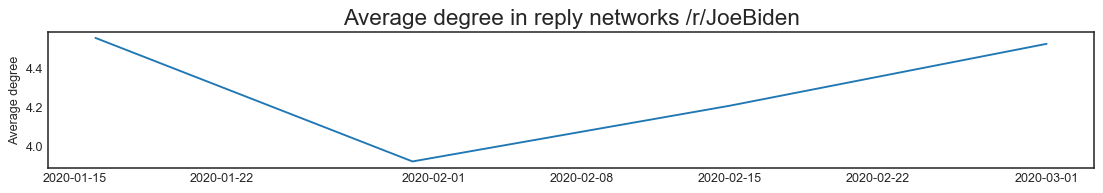

In [27]:
plt.figure(figsize = (15,2), dpi = 90)
plt.plot(experiment_dates, average_degreee)
plt.title(f"Average degree in reply networks /r/{subreddit_name}", fontsize = 18)
plt.ylabel("Average degree")
plt.show()

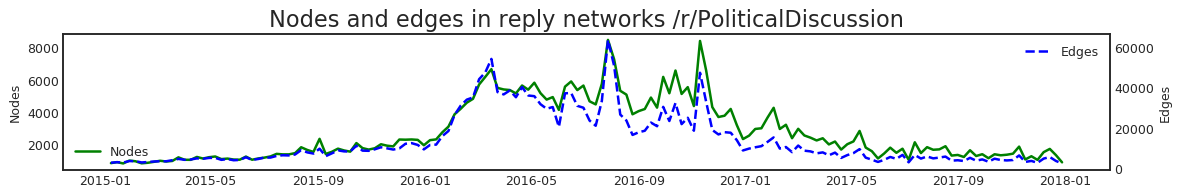

In [49]:
plt.figure(figsize = (15,2), dpi = 90)
plt.title(f"Nodes and edges in reply networks /r/{subreddit_name}", fontsize = 18)
plt.plot(experiment_dates, active_nodes, lw = 2, ls = "-", color = "green", 
         label = "Nodes")
plt.ylabel("Nodes")
plt.legend(loc = 3)
ax = plt.twinx()
ax.plot(experiment_dates, edges, lw = 2, ls = "--",  color = "blue", 
        label = "Edges")
ax.set_ylabel("Edges")
plt.legend(loc = 1)
plt.show()

In [51]:
out_dir = os.path.join(comptech_opinion_analizer_path, "data/reply_networks")
os.makedirs(out_dir, exist_ok = True)
out_networks_file = f"./commenting_networks_{subreddit_name}.pkl"
out_networks_path = os.path.join(out_dir, out_networks_file)
pickle.dump((experiment_dates, experiment_C), open(out_networks_path, "wb"))